In [1]:
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "VADER is very smart, handsome, and funny.", # booster words handled correctly (sentiment intensity adjusted)
             "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
             "VADER is VERY SMART, handsome, and FUNNY!!!", # combination of signals - VADER appropriately adjusts intensity
             "VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!", # booster words & punctuation make this close to ceiling for score
             "VADER is not smart, handsome, nor funny.",  # negation sentence example
             "The book was good.",  # positive sentence
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

## VaderSentiment

https://github.com/cjhutto/vaderSentiment

In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [3]:
def get_vader_sentiment(text):
    vs = analyzer.polarity_scores(text).pop('compound', None)
    if vs > 0.05:
        return 'POS'
    
    elif vs < -0.05:
        return 'NEG'
    
    return 'NEU'

In [4]:
for s in sentences:
    print(get_vader_sentiment(s),":", s)

POS : VADER is smart, handsome, and funny.
POS : VADER is smart, handsome, and funny!
POS : VADER is very smart, handsome, and funny.
POS : VADER is VERY SMART, handsome, and FUNNY.
POS : VADER is VERY SMART, handsome, and FUNNY!!!
POS : VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
NEG : VADER is not smart, handsome, nor funny.
POS : The book was good.
POS : At least it isn't a horrible book.
POS : The book was only kind of good.
NEG : The plot was good, but the characters are uncompelling and the dialog is not great.
NEG : Today SUX!
POS : Today only kinda sux! But I'll get by, lol
POS : Make sure you :) or :D today!
POS : Catch utf-8 emoji such as such as 💘 and 💋 and 😁
POS : Not bad at all


## Transformers

https://github.com/cardiffnlp/tweeteval

In [5]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

MODELPATH = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODELPATH)
model = AutoModelForSequenceClassification.from_pretrained(MODELPATH)
model.save_pretrained(MODELPATH)
tokenizer.save_pretrained(MODELPATH)

('cardiffnlp/twitter-roberta-base-sentiment/tokenizer_config.json',
 'cardiffnlp/twitter-roberta-base-sentiment/special_tokens_map.json',
 'cardiffnlp/twitter-roberta-base-sentiment/vocab.json',
 'cardiffnlp/twitter-roberta-base-sentiment/merges.txt',
 'cardiffnlp/twitter-roberta-base-sentiment/added_tokens.json',
 'cardiffnlp/twitter-roberta-base-sentiment/tokenizer.json')

In [6]:
#https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt
mapping = {0: 'NEG', 1: 'NEU', 2:'POS'}

In [7]:
def get_transformers_sentiment(text):
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    ranking = np.argsort(scores)
    ranking = ranking[::-1][0]
    result = mapping[ranking]
    
    return result

In [8]:
for s in sentences:
    print(get_transformers_sentiment(s),":", s)

POS : VADER is smart, handsome, and funny.
POS : VADER is smart, handsome, and funny!
POS : VADER is very smart, handsome, and funny.
POS : VADER is VERY SMART, handsome, and FUNNY.
POS : VADER is VERY SMART, handsome, and FUNNY!!!
POS : VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
NEG : VADER is not smart, handsome, nor funny.
POS : The book was good.
NEU : At least it isn't a horrible book.
POS : The book was only kind of good.
NEG : The plot was good, but the characters are uncompelling and the dialog is not great.
NEU : Today SUX!
NEU : Today only kinda sux! But I'll get by, lol
POS : Make sure you :) or :D today!
NEU : Catch utf-8 emoji such as such as 💘 and 💋 and 😁
POS : Not bad at all


## Comparison

In [9]:
for s in sentences:
    v = get_vader_sentiment(s)
    t = get_transformers_sentiment(s)
    print("Matching? ", v == t, "      Sentence: ", s)
    print("Vader: ", v, "     ", "Transformers: ", t, "\n")

Matching?  True       Sentence:  VADER is smart, handsome, and funny.
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is smart, handsome, and funny!
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is very smart, handsome, and funny.
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is VERY SMART, handsome, and FUNNY.
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is VERY SMART, handsome, and FUNNY!!!
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is VERY SMART, uber handsome, and FRIGGIN FUNNY!!!
Vader:  POS       Transformers:  POS 

Matching?  True       Sentence:  VADER is not smart, handsome, nor funny.
Vader:  NEG       Transformers:  NEG 

Matching?  True       Sentence:  The book was good.
Vader:  POS       Transformers:  POS 

Matching?  False       Sentence:  At least it isn't a horrible book.
Vader:  POS       Transformers:  NEU

### Our case

In [10]:
import pandas as pd
import re
from tqdm import tqdm

In [11]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [12]:
def preprocess(text):
    new_text = []
 
 
    for t in text.split(" "):
        t = '' if t.startswith('@') and len(t) > 1 else t
        t = '' if t.startswith('http') else t
        t = '' if t.startswith('$') else t
        
        new_text.append(t)
    return " ".join(new_text)

In [13]:
t = pd.read_csv("data/tweets.csv")
t["clean"] = [preprocess(i) for i in t.text]

In [14]:
t["vader"] = [get_vader_sentiment(s) for s in t.clean]

In [15]:
t["vader_int"] = t.vader.replace({'POS':1,'NEU':0,'NEG':-1})

In [16]:
t.head()

,text,time,clean,vader,vader_int
0,$XRP.X,2022-01-07 16:07:00,,NEU,0
1,$XRP.X https://www.sec.gov/news/press-release/...,2022-01-07 16:07:00,why are they always in trouble ? Wtf🤷🏾‍♂️😂,NEG,-1
2,$XRP.X This is a golden opportunity for us mul...,2022-01-07 16:08:00,This is a golden opportunity for us multiyear...,POS,1
3,$XRP.X $ETH.X $BTC.X $ACH.X $HBAR.X ”LETS GO C...,2022-01-07 16:16:00,”LETS GO CHINA”!,NEU,0
4,$XRP.X $BTC.X $SPY I was looking for Biden’s l...,2022-01-07 16:19:00,I was looking for Biden’s live speech he’s ...,NEG,-1


In [17]:
tosum = t[['time', 'vader_int']]
tosum["time"] = pd.to_datetime(tosum.time, utc = True) 
tosum["min"] = tosum.time.dt.floor("min")
tosum["min"] = tosum["min"].dt.tz_localize(None)
tosum["hour"] = tosum.time.dt.floor("H")
tosum["hour"] = tosum["hour"].dt.tz_localize(None)
tosum["day"] = tosum.time.dt.floor("D")
tosum["day"] = tosum["day"].dt.tz_localize(None)
tosum["pos"] = [1 if i == 1 else 0 for i in tosum.vader_int ]
tosum["neu"] = [1 if i == 0 else 0 for i in tosum.vader_int ]
tosum["neg"] = [1 if i == -1 else 0 for i in tosum.vader_int ]

/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_1752/4096569016.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tosum["time"] = pd.to_datetime(tosum.time, utc = True)
/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_1752/4096569016.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tosum["min"] = tosum.time.dt.floor("min")
/var/folders/3n/qb9qrmdn45q_rjlp5x6g7k5c0000gn/T/ipykernel_1752/4096569016.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [18]:
tosum

,time,vader_int,min,hour,day,pos,neu,neg
0,2022-01-07 16:07:00+00:00,0,2022-01-07 16:07:00,2022-01-07 16:00:00,2022-01-07,0,1,0
1,2022-01-07 16:07:00+00:00,-1,2022-01-07 16:07:00,2022-01-07 16:00:00,2022-01-07,0,0,1
2,2022-01-07 16:08:00+00:00,1,2022-01-07 16:08:00,2022-01-07 16:00:00,2022-01-07,1,0,0
3,2022-01-07 16:16:00+00:00,0,2022-01-07 16:16:00,2022-01-07 16:00:00,2022-01-07,0,1,0
4,2022-01-07 16:19:00+00:00,-1,2022-01-07 16:19:00,2022-01-07 16:00:00,2022-01-07,0,0,1
...,...,...,...,...,...,...,...,...
23191,2022-02-10 15:46:00+00:00,-1,2022-02-10 15:46:00,2022-02-10 15:00:00,2022-02-10,0,0,1
23192,2022-02-10 15:50:00+00:00,0,2022-02-10 15:50:00,2022-02-10 15:00:00,2022-02-10,0,1,0
23193,2022-02-10 15:50:00+00:00,-1,2022-02-10 15:50:00,2022-02-10 15:00:00,2022-02-10,0,0,1
23194,2022-02-10 15:55:00+00:00,0,2022-02-10 15:55:00,2022-02-10 15:00:00,2022-02-10,0,1,0


### Minute

In [55]:
minutesum

,min,vader_int,pos,neu,neg,total
0,2022-01-07 00:01:00,2,2,0,0,2
1,2022-01-07 00:07:00,2,2,0,0,2
2,2022-01-07 00:18:00,-1,0,0,1,1
3,2022-01-07 00:34:00,-2,0,0,2,2
4,2022-01-07 00:38:00,0,0,2,0,2
...,...,...,...,...,...,...
10651,2022-02-28 23:39:00,0,0,2,0,2
10652,2022-02-28 23:44:00,0,0,1,0,1
10653,2022-02-28 23:46:00,0,0,1,0,1
10654,2022-02-28 23:47:00,0,0,1,0,1


<AxesSubplot:xlabel='min'>

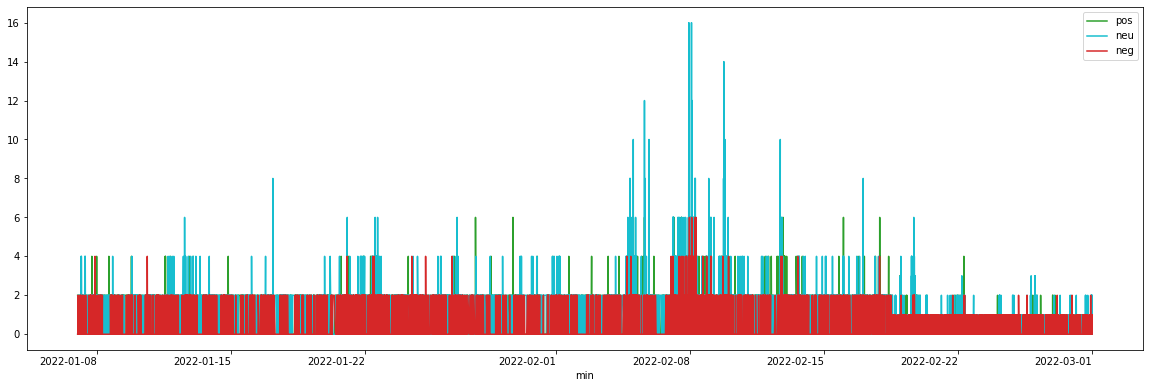

In [19]:
minutesum = tosum.groupby('min').sum()
minutesum["total"] = minutesum.pos + minutesum.neu + minutesum.neg
minutesum.iloc[:, 1:-1].plot(figsize = (20, 7), color = ["tab:green", "tab:cyan","tab:red"], rot = 0)

<AxesSubplot:xlabel='min'>

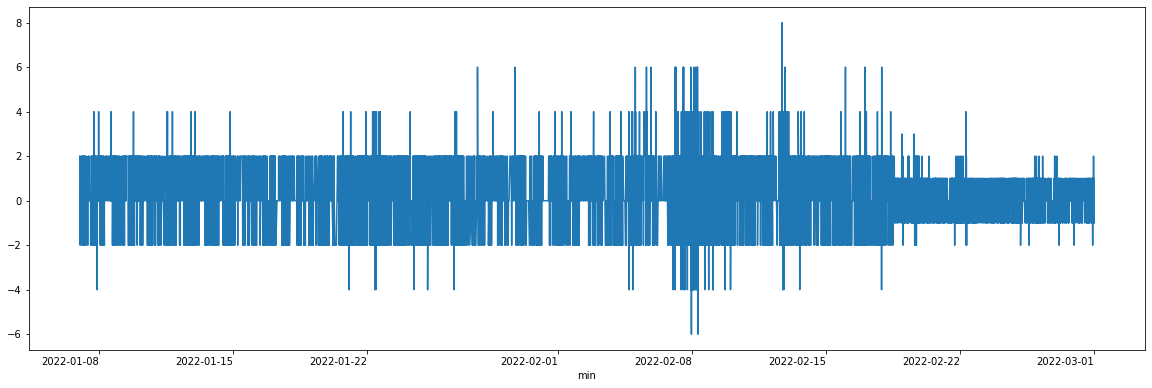

In [20]:
minutesum["vader_int"].plot(figsize = (20, 7), rot = 0)

#### Sentiment

In [22]:
print(minutesum.shape)
minutesum = minutesum.reset_index()
minutesum["ts"] = minutesum["min"].view('int64')
minutesum

(10656, 5)


,min,vader_int,pos,neu,neg,total,ts
0,2022-01-07 00:01:00,2,2,0,0,2,1641513660000000000
1,2022-01-07 00:07:00,2,2,0,0,2,1641514020000000000
2,2022-01-07 00:18:00,-1,0,0,1,1,1641514680000000000
3,2022-01-07 00:34:00,-2,0,0,2,2,1641515640000000000
4,2022-01-07 00:38:00,0,0,2,0,2,1641515880000000000
...,...,...,...,...,...,...,...
10651,2022-02-28 23:39:00,0,0,2,0,2,1646091540000000000
10652,2022-02-28 23:44:00,0,0,1,0,1,1646091840000000000
10653,2022-02-28 23:46:00,0,0,1,0,1,1646091960000000000
10654,2022-02-28 23:47:00,0,0,1,0,1,1646092020000000000


#### Prices

In [23]:
minuteprices = pd.read_csv("data/minute.csv")
minuteprices.time = pd.to_datetime(minuteprices.time,infer_datetime_format = True,  utc = True)
minuteprices.time = minuteprices.time.dt.tz_localize(None)
minuteprices["ts"] = minuteprices["time"].view('int64')
print(minuteprices.shape)
minuteprices

(76312, 7)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,ts
0,2022-01-07 00:01:00,43111.50,467.965,19.385,1791.52500,0.72640,1641513660000000000
1,2022-01-07 00:02:00,43107.25,467.965,19.385,1791.46250,0.72640,1641513720000000000
2,2022-01-07 00:03:00,43112.75,467.965,19.385,1791.53250,0.72645,1641513780000000000
3,2022-01-07 00:04:00,43091.25,467.965,19.385,1791.63250,0.72665,1641513840000000000
4,2022-01-07 00:05:00,43080.50,467.965,19.385,1791.76250,0.72665,1641513900000000000
...,...,...,...,...,...,...,...
76307,2022-02-28 23:48:00,43178.50,436.600,24.035,1906.74000,0.77130,1646092080000000000
76308,2022-02-28 23:49:00,43211.00,436.600,24.035,1906.86250,0.77125,1646092140000000000
76309,2022-02-28 23:50:00,43235.00,436.600,24.035,1906.75250,0.77100,1646092200000000000
76310,2022-02-28 23:51:00,43253.00,436.600,24.035,1906.65925,0.77065,1646092260000000000


#### Join

In [24]:
print("Shape tweets join:", minutesum.shape)
print("Shape prices join:", minuteprices.shape)
minutedf = minuteprices.join(minutesum, lsuffix='ts', rsuffix='ts', how = "left")
print("Shape after join:", minutedf.shape)
minutedf = minutedf.drop(['min'], axis = 1)
minutedf

Shape tweets join: (10656, 7)
Shape prices join: (76312, 7)
Shape after join: (76312, 14)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,tsts,vader_int,pos,neu,neg,total,tsts
0,2022-01-07 00:01:00,43111.50,467.965,19.385,1791.52500,0.72640,1641513660000000000,2.0,2.0,0.0,0.0,2.0,1.641514e+18
1,2022-01-07 00:02:00,43107.25,467.965,19.385,1791.46250,0.72640,1641513720000000000,2.0,2.0,0.0,0.0,2.0,1.641514e+18
2,2022-01-07 00:03:00,43112.75,467.965,19.385,1791.53250,0.72645,1641513780000000000,-1.0,0.0,0.0,1.0,1.0,1.641515e+18
3,2022-01-07 00:04:00,43091.25,467.965,19.385,1791.63250,0.72665,1641513840000000000,-2.0,0.0,0.0,2.0,2.0,1.641516e+18
4,2022-01-07 00:05:00,43080.50,467.965,19.385,1791.76250,0.72665,1641513900000000000,0.0,0.0,2.0,0.0,2.0,1.641516e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76307,2022-02-28 23:48:00,43178.50,436.600,24.035,1906.74000,0.77130,1646092080000000000,NaN,NaN,NaN,NaN,NaN,NaN
76308,2022-02-28 23:49:00,43211.00,436.600,24.035,1906.86250,0.77125,1646092140000000000,NaN,NaN,NaN,NaN,NaN,NaN
76309,2022-02-28 23:50:00,43235.00,436.600,24.035,1906.75250,0.77100,1646092200000000000,NaN,NaN,NaN,NaN,NaN,NaN
76310,2022-02-28 23:51:00,43253.00,436.600,24.035,1906.65925,0.77065,1646092260000000000,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
minutedf.isna().sum()

time             0
BTC_price        0
SPY_price        0
VXX_price        0
XAU_price        0
XRP_price        0
tsts             0
vader_int    65656
pos          65656
neu          65656
neg          65656
total        65656
tsts         65656
dtype: int64

### Hour

,vader_int,pos,neu,neg,total
hour,,,,,
2022-01-07 00:00:00,0,4,3,4,11
2022-01-07 01:00:00,0,2,2,2,6
2022-01-07 02:00:00,3,3,4,0,7
2022-01-07 03:00:00,1,5,12,4,21
2022-01-07 04:00:00,8,12,12,4,28


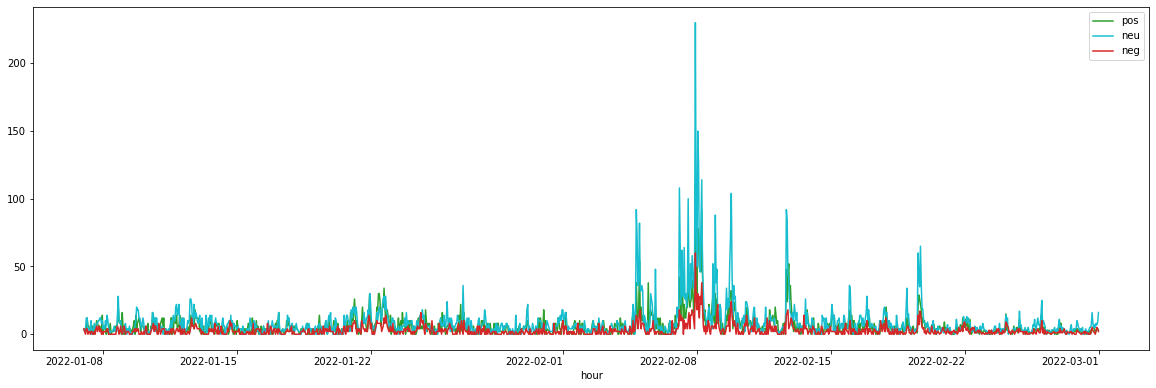

In [26]:
hoursum = tosum.groupby('hour').sum()
hoursum["total"] = hoursum.pos + hoursum.neu + hoursum.neg
hoursum.iloc[:, 1:-1].plot(figsize = (20, 7), color = ["tab:green", "tab:cyan","tab:red"], rot = 0)
hoursum.head()

<AxesSubplot:xlabel='hour'>

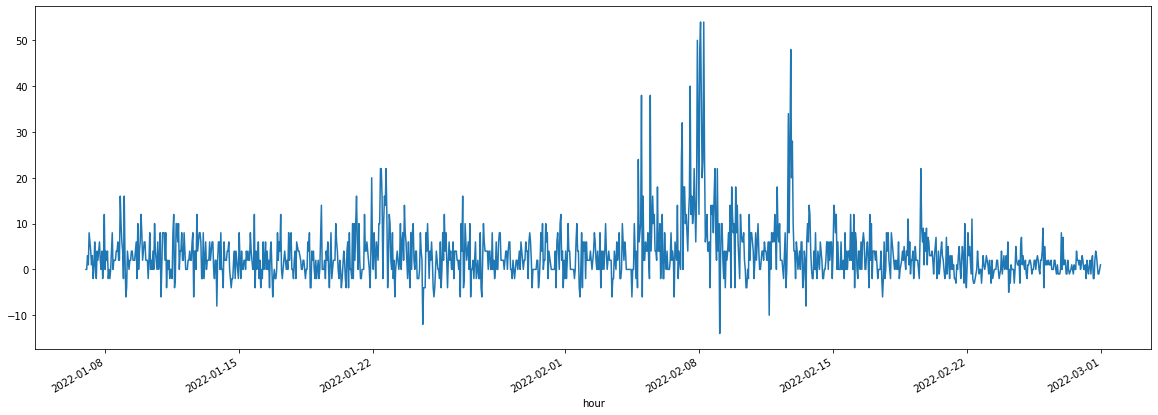

In [27]:
hoursum["vader_int"].plot(figsize = (20, 7))

In [46]:
hoursum = hoursum.reset_index()
hoursum

,index,hour,vader_int,pos,neu,neg,total
0,0,2022-01-07 00:00:00,0,4,3,4,11
1,1,2022-01-07 01:00:00,0,2,2,2,6
2,2,2022-01-07 02:00:00,3,3,4,0,7
3,3,2022-01-07 03:00:00,1,5,12,4,21
4,4,2022-01-07 04:00:00,8,12,12,4,28
...,...,...,...,...,...,...,...
1250,1250,2022-02-28 19:00:00,1,1,5,0,6
1251,1251,2022-02-28 20:00:00,-1,2,8,3,13
1252,1252,2022-02-28 21:00:00,-1,4,7,5,16
1253,1253,2022-02-28 22:00:00,0,4,9,4,17


In [45]:
hourprices = pd.read_csv("data/hour.csv")
hourprices

,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-07 01:00:00,42891.00,467.965,19.385,1791.39075,0.72155
1,2022-01-07 02:00:00,42898.00,467.965,19.385,1791.21500,0.72175
2,2022-01-07 03:00:00,42297.00,467.965,19.385,1792.26825,0.71825
3,2022-01-07 04:00:00,41748.25,467.965,19.385,1792.75150,0.71385
4,2022-01-07 05:00:00,41767.75,467.965,19.385,1791.73325,0.71880
...,...,...,...,...,...,...
1266,2022-02-28 19:00:00,41297.00,433.750,24.400,1902.71450,0.78145
1267,2022-02-28 20:00:00,41631.00,434.765,24.265,1908.32500,0.77320
1268,2022-02-28 21:00:00,41785.75,436.600,24.035,1909.55875,0.77065
1269,2022-02-28 22:00:00,42352.75,436.600,24.035,1908.97000,0.77070


In [47]:
print("Tweets shape:", hoursum.shape)
print("Prices shape:", hourprices.shape)

hourdf = hourprices.join(hoursum, lsuffix='time', rsuffix='day', how = "left")
print("Joined shape", hourdf.shape)
hourdf

Tweets shape: (1255, 7)
Prices shape: (1271, 6)
Joined shape (1271, 13)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,index,hour,vader_int,pos,neu,neg,total
0,2022-01-07 01:00:00,42891.00,467.965,19.385,1791.39075,0.72155,0.0,2022-01-07 00:00:00,0.0,4.0,3.0,4.0,11.0
1,2022-01-07 02:00:00,42898.00,467.965,19.385,1791.21500,0.72175,1.0,2022-01-07 01:00:00,0.0,2.0,2.0,2.0,6.0
2,2022-01-07 03:00:00,42297.00,467.965,19.385,1792.26825,0.71825,2.0,2022-01-07 02:00:00,3.0,3.0,4.0,0.0,7.0
3,2022-01-07 04:00:00,41748.25,467.965,19.385,1792.75150,0.71385,3.0,2022-01-07 03:00:00,1.0,5.0,12.0,4.0,21.0
4,2022-01-07 05:00:00,41767.75,467.965,19.385,1791.73325,0.71880,4.0,2022-01-07 04:00:00,8.0,12.0,12.0,4.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266,2022-02-28 19:00:00,41297.00,433.750,24.400,1902.71450,0.78145,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1267,2022-02-28 20:00:00,41631.00,434.765,24.265,1908.32500,0.77320,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1268,2022-02-28 21:00:00,41785.75,436.600,24.035,1909.55875,0.77065,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1269,2022-02-28 22:00:00,42352.75,436.600,24.035,1908.97000,0.77070,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [44]:
hourdf.isna().sum()

time          0
BTC_price     0
SPY_price     0
VXX_price     0
XAU_price     0
XRP_price     0
hour         16
vader_int    16
pos          16
neu          16
neg          16
total        16
dtype: int64

### Day 

<AxesSubplot:xlabel='day'>

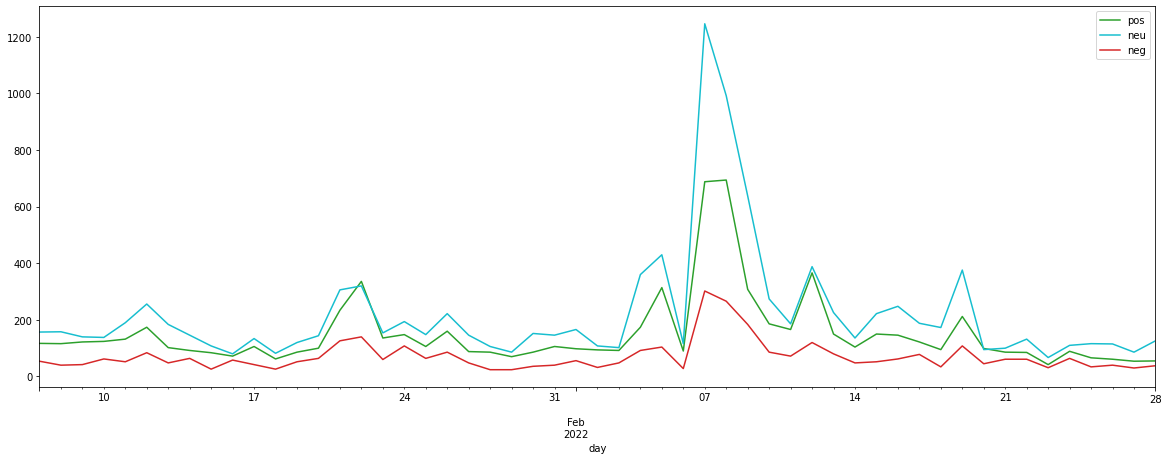

In [28]:
daysum = tosum.groupby('day').sum()
daysum["total"] = daysum.pos + daysum.neu + daysum.neg
daysum.iloc[:, 1:-1].plot(figsize = (20, 7), color = ["tab:green", "tab:cyan","tab:red"], rot = 0)

<AxesSubplot:xlabel='day'>

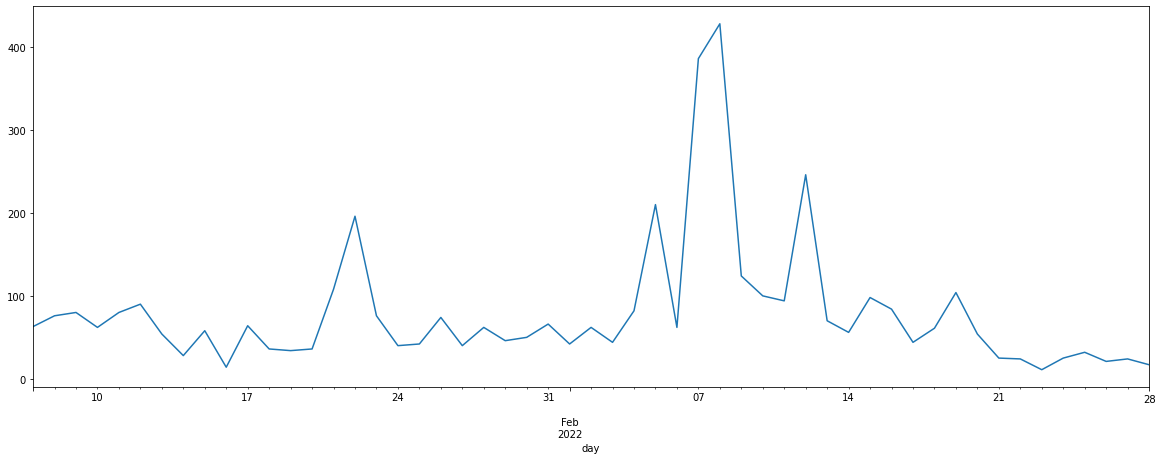

In [34]:
daysum["vader_int"].plot(figsize = (20, 7), rot = 0)

#### Sentiment

In [35]:
daysum = daysum.reset_index()
daysum.head()

,day,vader_int,pos,neu,neg,total
0,2022-01-07,63,117,157,54,328
1,2022-01-08,76,116,158,40,314
2,2022-01-09,80,122,140,42,304
3,2022-01-10,62,124,138,62,324
4,2022-01-11,80,132,190,52,374


#### Prices

In [36]:
dayprices = pd.read_csv("data/day.csv")
dayprices.head()

,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price
0,2022-01-08,41620.75,466.115,18.8200,1796.37500,0.76140
1,2022-01-09,41777.50,466.115,18.8200,1795.09750,0.76160
2,2022-01-10,41845.25,464.080,19.0200,1798.24325,0.76145
3,2022-01-11,42282.75,467.485,18.2650,1811.06075,0.76130
4,2022-01-12,43325.50,471.330,17.6275,1823.09325,0.76125


#### Join

In [37]:
print("Tweets shape:", daysum.shape)
print("Prices shape:", dayprices.shape)

daydf = dayprices.join(daysum, lsuffix='time', rsuffix='day', how = "left")
print("Joined shape", daydf.shape)
daydf.head()

Tweets shape: (53, 6)
Prices shape: (52, 6)
Joined shape (52, 12)


,time,BTC_price,SPY_price,VXX_price,XAU_price,XRP_price,day,vader_int,pos,neu,neg,total
0,2022-01-08,41620.75,466.115,18.8200,1796.37500,0.76140,2022-01-07,63,117,157,54,328
1,2022-01-09,41777.50,466.115,18.8200,1795.09750,0.76160,2022-01-08,76,116,158,40,314
2,2022-01-10,41845.25,464.080,19.0200,1798.24325,0.76145,2022-01-09,80,122,140,42,304
3,2022-01-11,42282.75,467.485,18.2650,1811.06075,0.76130,2022-01-10,62,124,138,62,324
4,2022-01-12,43325.50,471.330,17.6275,1823.09325,0.76125,2022-01-11,80,132,190,52,374


In [38]:
daydf.isna().sum()

time         0
BTC_price    0
SPY_price    0
VXX_price    0
XAU_price    0
XRP_price    0
day          0
vader_int    0
pos          0
neu          0
neg          0
total        0
dtype: int64